In this notebook we create a simple way to extract nodes and all (possible) edges in a graph-like representation that is depicted in an image.  
First of all, we will import the necessary libraries:

In [1]:
from dotenv import load_dotenv
from google import genai
from PIL import Image
from pydantic import BaseModel, Field
from typing import List

We will use Gemini (via Google AI API) to extract the components from the graph in the image. As an answer, we'd only like to receive a JSON with each node and its coordinates and the edges between each node. Therefore, we will define the structures with Pydantic and later request this kind of response to the LLM.  
Note: a dictionary mapping each node (key) with its coordinates (x, y) could have been used instead, but the *additionalProperties* that are created within it are not supported. That's why  we use a couple of lists.

In [2]:
class NodeData(BaseModel):
    node_id: int = Field(description = "The integer ID of the node")
    x: int = Field(description = "The x coordinate of the node")
    y: int = Field(description = "The y coordinate of the node")

class ImageExtractedGraphElements(BaseModel):
    nodes_dict: List[NodeData] = Field(
        description = "List of all node IDs and their (x, y) pixel coordinates."
    )
    edges_list: List[List[int]] = Field(
        description = "A list of tuples where each tuple (u, v) represents an edge between node u and node v."
    )

In [3]:
load_dotenv()  # This looks for the .env file and loads the variables
client = genai.Client() # Create the GenAI client, it'll directly use the GEMINI_API_KEY variable

In [ ]:
image = Image.open("images/example_path_graph.png")  # Loading the graph image

# Ask Gemini to fill in that structure
response = client.models.generate_content(
    model="gemini-3-flash-preview",
    contents = [
        """
        Analyze the image below. It represents a graph with nodes and edges. Your task is to extract the graph elements following these steps:
        1. Map every node to a unique ID and its $(x, y)$ coordinates.
        2. Identify the edges by checking the spatial relationship: an edge exists between two nodes if they are meant to be connected and the path between them is direct.
        * Strict rule: Do not create an edge between two nodes if that edge would physically pass through or overlap a third node.
        * Strict rule: Only consider horizontal and vertical connections for edges; diagonal connections are not allowed.
        3. Return the result in the specified JSON schema.
        """,
        image
    ],
    config = {
        'response_mime_type': 'application/json',
        'response_schema': ImageExtractedGraphElements,
    }
)

In [5]:
# 3. Use the data as native Python variables
data = response.parsed  # This is an instance of ImageExtractedGraphElements
nodes = data.nodes_dict
edges = data.edges_list

node_dict = {node.node_id: (node.x, node.y) for node in nodes}
edge_list = [tuple(edge) for edge in edges]

print(f"Dictionary: {node_dict}")
print(f"List: {edge_list}")

Dictionary: {0: (753, 151), 1: (174, 281), 2: (372, 281), 3: (569, 282), 4: (771, 281), 5: (135, 436), 6: (362, 434), 7: (584, 437), 8: (799, 438), 9: (93, 624), 10: (337, 623), 11: (584, 627), 12: (833, 630), 13: (877, 871)}
List: [(0, 4), (1, 2), (1, 5), (2, 3), (2, 6), (3, 4), (3, 7), (4, 8), (5, 6), (5, 9), (6, 7), (6, 10), (7, 8), (7, 11), (8, 12), (9, 10), (10, 11), (11, 12), (12, 13)]


Let's now graph what Gemini has given to us

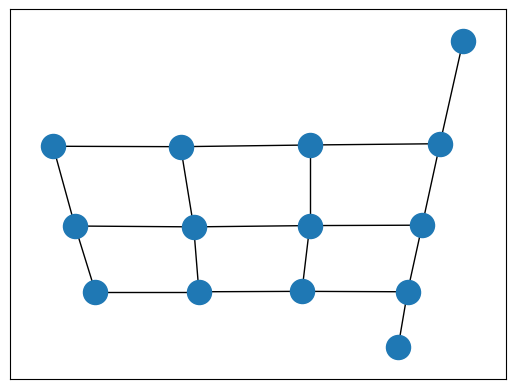

In [6]:
import networkx as nx
import matplotlib.pyplot as plt

# Initialize an undirected graph
G = nx.Graph()

G.add_nodes_from(node_dict.keys())
G.clear_edges() # Clear any existing edges
G.add_edges_from(edge_list)

plt.tight_layout()
nodes_horizontal = nx.draw_networkx_nodes(G, pos=node_dict)
edges = nx.draw_networkx_edges(G, pos=node_dict)
plt.show()